In [1]:
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from os.path import join, abspath
from os import pardir
import sys
import vaex
import corner
from tqdm import tqdm

In [2]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import load_data, plot_data, run_mcmc, nu_mod, fw, log_prior, log_posterior_dm

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [6]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution")
data_eff_dir = join(root_data_dir, "Effective-Volume")
data_dir = join(root_data_dir, "MCMC")

In [7]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [8]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

# Functions

In [20]:
def initialize_prior_dm(rhos, sigmaz, e_rhos, e_sigmaz, w0, sigma_w, a_raw, dim):
    locs = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        log_rhoDM=-4, 
        log_nu0=np.log(1E-5), 
        zsun=-20, 
        R=3.4E-3, 
        w0=w0-5, 
        log_sigma_w=np.log(sigma_w*0.7), 
        a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
    )
    
    scales = dict(
        rhos=e_rhos,
        sigmaz=e_sigmaz,
        log_rhoDM=2, 
        log_nu0=np.log(1E-4)-locs['log_nu0'], 
        zsun=20-locs['zsun'], 
        R=0.6E-3, 
        w0=np.repeat(10, dim), 
        log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
        a=np.abs(a_raw*0.6)
    )
    uni_list_DM = ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
    norm_list_DM = ['R', 'rhos', 'sigmaz']
    return locs, scales, uni_list_DM, norm_list_DM

In [10]:
def initialize_walkers_dm(locs, scales, dim):
    theta = np.concatenate([np.ravel(x) for x in locs.values()])
    ndim = len(theta)
    nwalkers = ndim*2+1

    rhos_0 = np.random.normal(loc=locs['rhos'], scale=scales['rhos'], size=(nwalkers, 12))
    sigmaz_0 = np.random.normal(loc=locs['sigmaz'], scale=scales['sigmaz'], size=(nwalkers, 12))
    log_rhoDM_0 = np.random.uniform(low=locs['log_rhoDM'], high=locs['log_rhoDM']+scales['log_rhoDM'], size=nwalkers)
    log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
    zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
    R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
    w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
    log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
    a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

    p0 = np.array([*rhos_0.T, *sigmaz_0.T, log_rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    return p0, ndim, nwalkers

In [11]:
def plot_corner_dm(sampler, path=None):
    flat_samples = sampler.get_chain(flat=True).copy()
    flat_samples[:, 24+0] = np.exp(flat_samples[:, 24+0])/1E-2
    flat_samples[:, 24+1] = np.exp(flat_samples[:, 24+1])/1E-5
    flat_samples[:, 24+3] = flat_samples[:, 24+3]/1E-3
    flat_samples[:, 24+4] = np.sum(flat_samples[:, :12], axis=1)/1E-2
    flat_samples = flat_samples[:, 24:24+5]
    labels = [r"$\rho_{DM}\times 10^2$",r"$\nu_0 \times10^5$ " , r"$z_{\odot}$", r"$R\times 10^3$", r"$\rho_{b}\times 10^2$"]
    fig = corner.corner(
        flat_samples, labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, title_kwargs={"fontsize": 12},
    )
    if path is not None:
        fig.savefig(path, dpi=300)

In [12]:
def plot_fitting_dm(sampler, data, dim, alpha=0.01, n=200, path=None):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    # plot two subplot
    flat_samples = sampler.get_chain(flat=True).copy()
    zs = np.linspace(-200, 200, 100)
    ws = np.linspace(-70, 70, 1000)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='o', label='data')
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$\rho(z)$')
    axes[0].legend()
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
    axes[1].set_xlabel(r'w')
    axes[1].set_ylabel(r'num')
    axes[1].legend()
    for i in tqdm(range(n)):
        index = np.random.randint(0, len(flat_samples))
        theta_dict = dict(
            rhos=flat_samples[index, :12], 
            sigmaz=flat_samples[index, 12:24], 
            rhoDM=np.exp(flat_samples[index, 24]),
            sigmaDD=0, 
            hDD=1, 
            nu0=np.exp(flat_samples[index, 25]),
            zsun=flat_samples[index, 26],
            R=flat_samples[index, 27],
            w0=flat_samples[index, 28:28+dim],
            sigma_w=np.exp(flat_samples[index, 28+dim:28+2*dim]),
            a=flat_samples[index, 28+2*dim:28+3*dim]
        )
        nu = nu_mod(zs, **theta_dict)
        axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
        Fw = fw(ws, **theta_dict)
        axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
    if path is not None:
        fig.savefig(path, dpi=300)
    plt.show()

In [13]:
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()

# main program

In [21]:
index = 0
data, dim, w0, sigma_w, a_raw, name = load_data(index, number_files, velocity_files, velocity_popt_files)

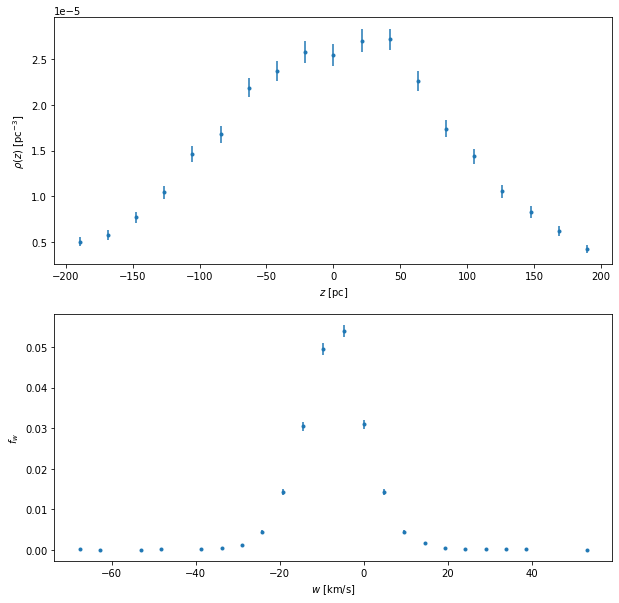

In [22]:
plot_data(data)

In [23]:
locs, scales, uni_list_DM, norm_list_DM = initialize_prior_dm(rhos, sigmaz, e_rhos, e_sigmaz, w0, sigma_w, a_raw, dim)
locs, scales, uni_list_DM, norm_list_DM

({'rhos': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
         0.0072, 0.0216, 0.0056, 0.0015]),
  'sigmaz': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
         20. ]),
  'log_rhoDM': -4,
  'log_nu0': -11.512925464970229,
  'zsun': -20,
  'R': 0.0034,
  'w0': array([-11.3139583 , -12.25885714]),
  'log_sigma_w': array([0.65521209, 1.70731399]),
  'a': array([0.05559131, 0.63791188])},
 {'rhos': array([3.12e-03, 5.54e-03, 7.00e-04, 3.00e-05, 6.00e-05, 1.80e-04,
         1.80e-04, 2.90e-04, 7.20e-04, 2.80e-03, 1.00e-03, 5.00e-04]),
  'sigmaz': array([0.2, 0.5, 2.4, 4. , 1.6, 2. , 2.4, 1.8, 1.9, 4. , 5. , 5. ]),
  'log_rhoDM': 2,
  'log_nu0': 2.302585092994047,
  'zsun': 40,
  'R': 0.0006,
  'w0': array([10, 10]),
  'log_sigma_w': array([0.61903921, 0.61903921]),
  'a': array([0.0476497 , 0.54678161])},
 ['log_rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a'],
 ['R', 'rhos', 'sigmaz'])

In [24]:
p0, ndim, nwalkers = initialize_walkers_dm(locs, scales, dim)

100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s]


Multiprocessing took 160.7 seconds


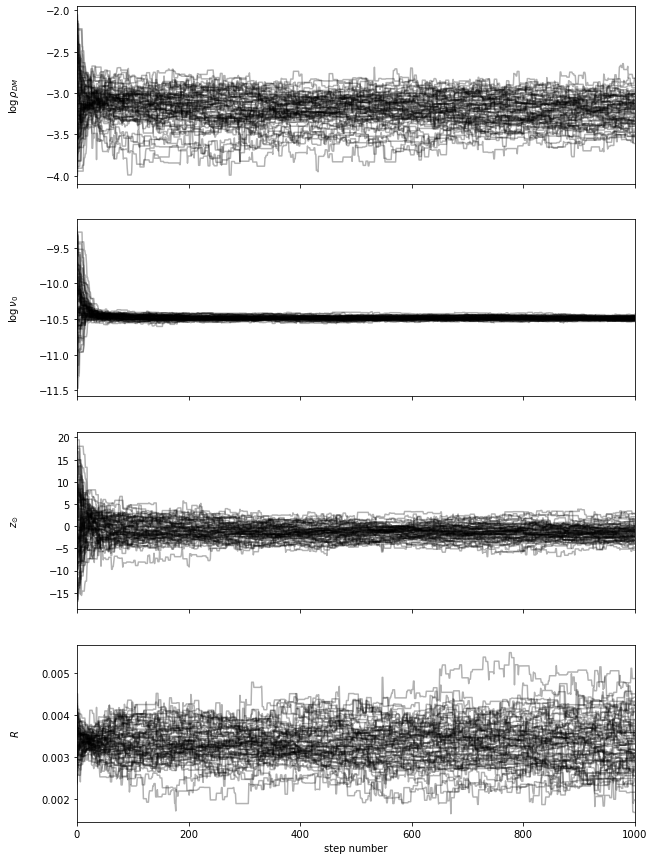

In [25]:
labels = [r"$\log \rho_{DM}$",r"$\log \nu_0$ " , r"$z_{\odot}$", r"$R$"]

sampler = run_mcmc(
    nwalkers, ndim, p0, labels, log_posterior_dm,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    cores=16, plot=True, skip=24, step=1000)

100%|██████████| 2000/2000 [08:43<00:00,  3.82it/s]


Multiprocessing took 523.9 seconds


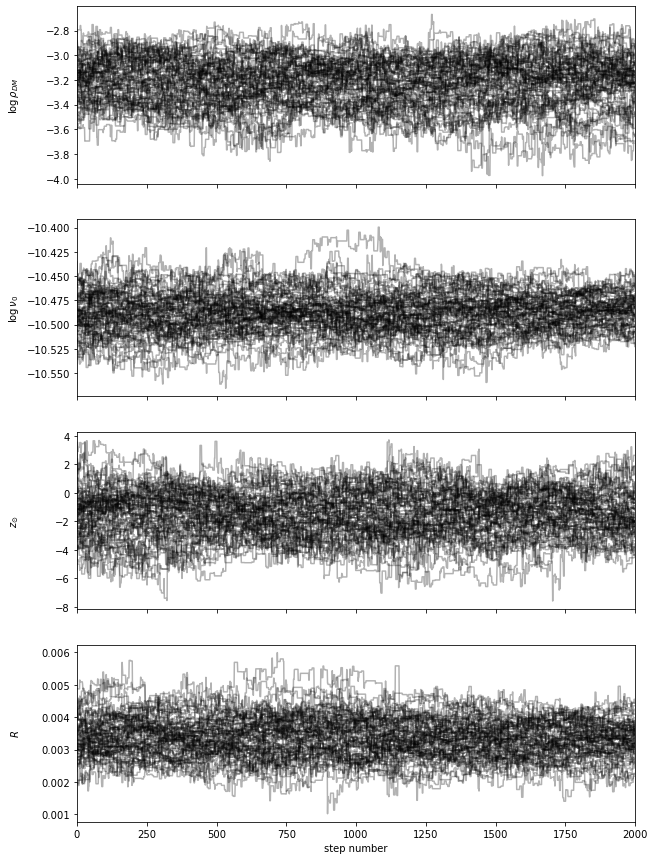

In [26]:
next_p0 = sampler.get_chain()[-1]
# next_p0 = sampler_new.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, labels, log_posterior_dm,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    cores=16, plot=True, skip=24, step=2000)

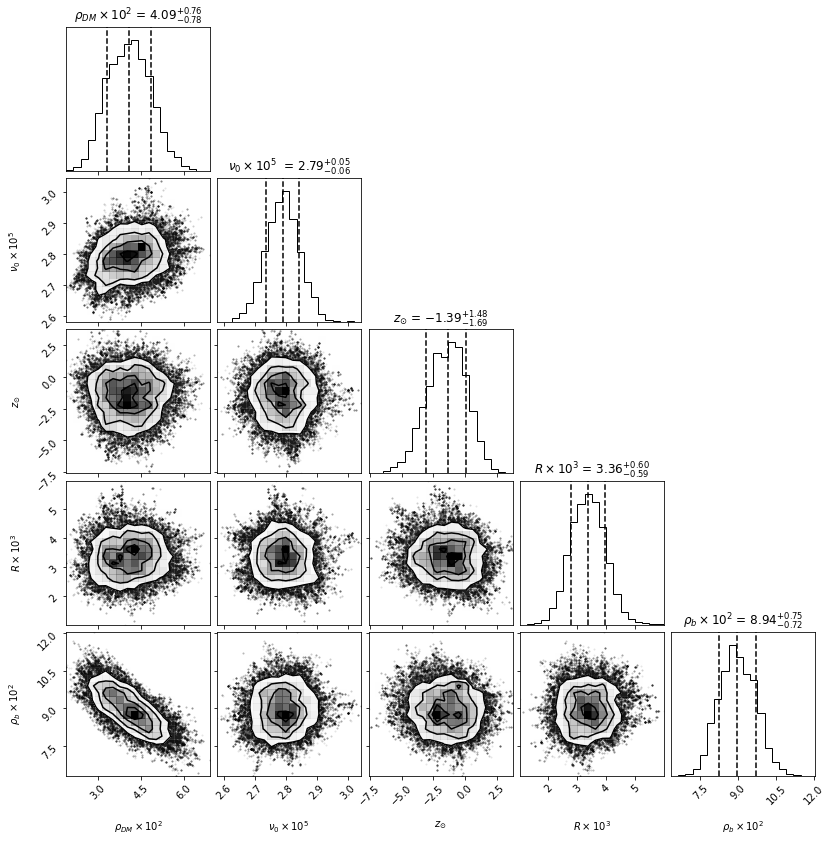

In [27]:
plot_corner_dm(sampler_new)

100%|██████████| 300/300 [03:29<00:00,  1.43it/s]


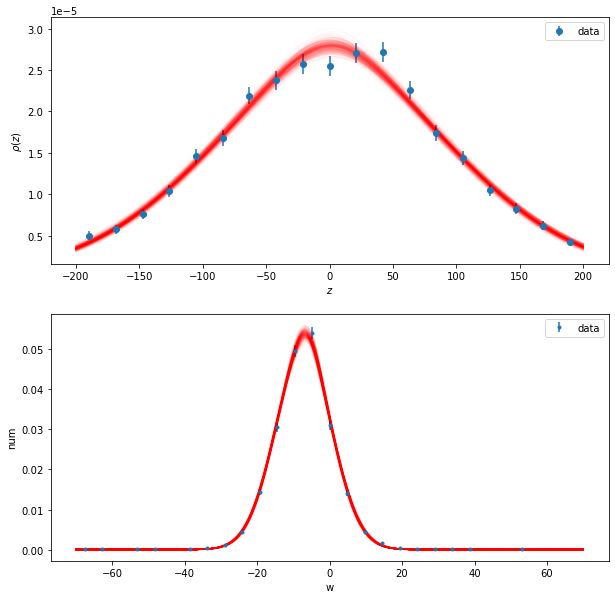

In [29]:
plot_fitting_dm(sampler_new, data, dim, alpha=0.02, n=300)

In [45]:
flat_samples = sampler.get_chain(flat=True).copy()
log_posterior = sampler.get_log_prob(flat=True).copy()
# save priors
log_priors = []
for samples in tqdm(flat_samples):
    theta = {
        "rhos": samples[:12],
        "sigmaz": samples[12:24],
        "log_rhoDM": samples[24],
        "log_nu0": samples[25],
        "zsun": samples[26],
        "R": samples[27],
        "w0": samples[28:28+dim],
        "log_sigma_w": samples[28+dim:28+2*dim],
        "a": samples[28+2*dim:28+3*dim]
    }
    lg_prior = log_prior(theta, locs, scales, norm_list_DM, uni_list_DM)
    log_priors.append(lg_prior)

log_priors = np.array(log_priors)
log_likelihood = log_posterior - log_priors

100%|██████████| 6900/6900 [00:12<00:00, 569.62it/s]


In [46]:
flat_samples = sampler.get_chain(flat=True).copy()
df_dm = {
    "log_rhoDM": flat_samples[:, 0],
    "log_nu0": flat_samples[:, 1],
    "zsun": flat_samples[:, 2],
    "R": flat_samples[:, 3],
}
for i in range(dim):
    df_dm[f"w0_{i}"] = flat_samples[:, 4+i]
    df_dm[f"log_sigma_w_{i}"] = flat_samples[:, 4+dim+i]
    df_dm[f"a_{i}"] = flat_samples[:, 4+2*dim+i]
for i in range(12):
    df_dm[f"rhos_{i}"] = flat_samples[:, i]
    df_dm[f"sigmaz_{i}"] = flat_samples[:, 12+i]
    
df_dm["log_likelihood"] = log_likelihood
df_dm["log_prior"] = log_priors
df_dm["log_posterior"] = log_posterior
df_dm = vaex.from_dict(df_dm)

df_dm.export(join(data_dir, f"dm_{name}.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.22s =  0.0m =  0.0h
 